In [1]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns

custom_params = {"axes.spines.right": False, 'grid.color': 'lightgray', 'axes.grid': True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from survivors import metrics as metr
import survivors.datasets as ds
import survivors.constants as cnt

%load_ext line_profiler
%load_ext scalene

Scalene extension successfully loaded. Note: Scalene currently only
supports CPU+GPU profiling inside Jupyter notebooks. For full Scalene
profiling, use the command line version.


In [17]:
glob_dir = os.path.join(os.path.split(os.path.split(os.getcwd())[0])[0], "experiment_results", "Backblaze")

========== backblaze16_18 ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$BaseLeafModel$                  0.5000     0.1527     0.4985  0.8795
$CoxPH$                          0.4202     0.1365     0.8194  0.8782
$KM$                             0.5000     0.1527     0.4985  0.8795
$LogLogisticAFT$                 0.4406     0.1448     0.8166  0.8595
$LogNormalAFT$                   0.4966     0.1403     0.5872  0.8328
$ST$                             0.5422     0.1415     0.6678  0.8641
$TREE_KMWV(d=1, l=CoxPH)$        0.5280     0.1477     0.5892  0.8878
$TREE_KMWV(d=1, l=WeibullAFT)$   0.5280     0.1601     0.5892  0.8858
$TREE_KMWV(d=1, l=base)$         0.5280     0.1478     0.5892  0.8878
$TREE_KMWV(d=10, l=CoxPH)$       0.5393     0.1516     0.7266  0.8553
$TREE_KMWV(d=10, l=WeibullAFT)$  0.5742     0.1899     0.6363  0.8151
$TREE_KMWV(d=10, l=base)$        0.6999     0.1473     0.6958  0.8822
$TREE_KMWV(d=2, l=CoxPH)$        0.5649     0.1343   

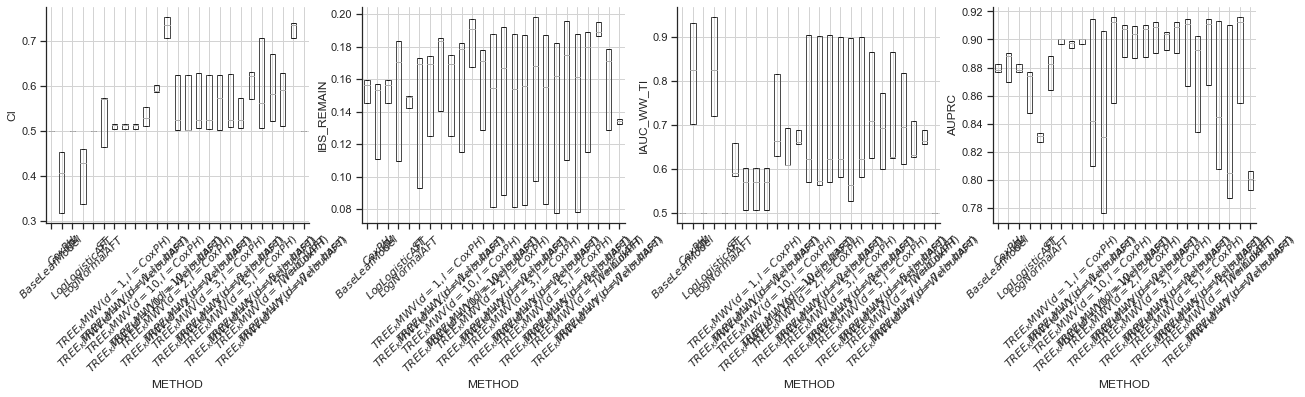

========== backblaze18_21 ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$BaseLeafModel$                  0.5000     0.1514     0.4992  0.8968
$CoxPH$                          0.5000     0.1514     0.4992  0.8952
$KM$                             0.5000     0.1514     0.4992  0.8968
$LogLogisticAFT$                 0.5972     0.1479     0.7454  0.8904
$LogNormalAFT$                   0.5349     0.1476     0.7365  0.8851
$ST$                             0.5222     0.1374     0.6070  0.8927
$TREE_KMWV(d=1, l=CoxPH)$        0.5883     0.1517     0.6122  0.9100
$TREE_KMWV(d=1, l=WeibullAFT)$   0.5883     0.1682     0.6113  0.9097
$TREE_KMWV(d=1, l=base)$         0.5875     0.1529     0.6016  0.9086
$TREE_KMWV(d=10, l=CoxPH)$       0.6480     0.1432     0.6660  0.8915
$TREE_KMWV(d=10, l=WeibullAFT)$  0.5623     0.2039     0.5656  0.7527
$TREE_KMWV(d=10, l=base)$        0.7358     0.1463     0.6374  0.9103
$TREE_KMWV(d=2, l=CoxPH)$        0.5775     0.1380   

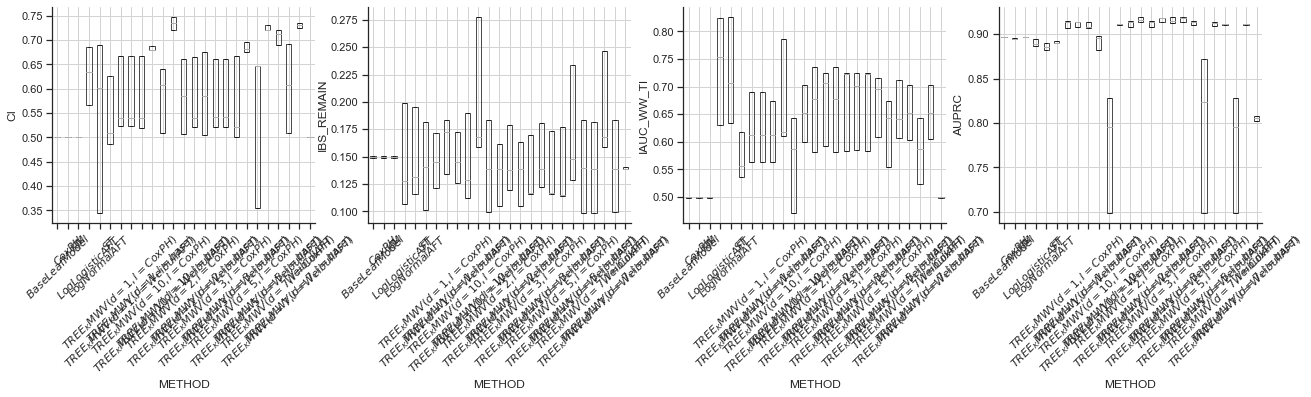

========== backblaze21_23 ==========
                                     CI IBS_REMAIN IAUC_WW_TI   AUPRC
$BaseLeafModel$                  0.5000     0.1514     0.4993  0.8322
$CoxPH$                          0.5531     0.1145     0.8261  0.8552
$KM$                             0.5000     0.1514     0.4993  0.8322
$LogLogisticAFT$                 0.6042     0.1169     0.8296  0.8244
$LogNormalAFT$                   0.5824     0.1199     0.8351  0.8245
$ST$                             0.5404     0.1247     0.7520  0.8467
$TREE_KMWV(d=1, l=CoxPH)$        0.4660     0.1322     0.6974  0.8728
$TREE_KMWV(d=1, l=WeibullAFT)$   0.4459     0.1359     0.6903  0.8683
$TREE_KMWV(d=1, l=base)$         0.5340     0.1322     0.6974  0.8728
$TREE_KMWV(d=10, l=CoxPH)$       0.6286     0.1256     0.7594  0.8690
$TREE_KMWV(d=10, l=WeibullAFT)$  0.6075     0.1866     0.6344  0.6448
$TREE_KMWV(d=10, l=base)$        0.7535     0.1279     0.7451  0.8695
$TREE_KMWV(d=2, l=CoxPH)$        0.4682     0.1266   

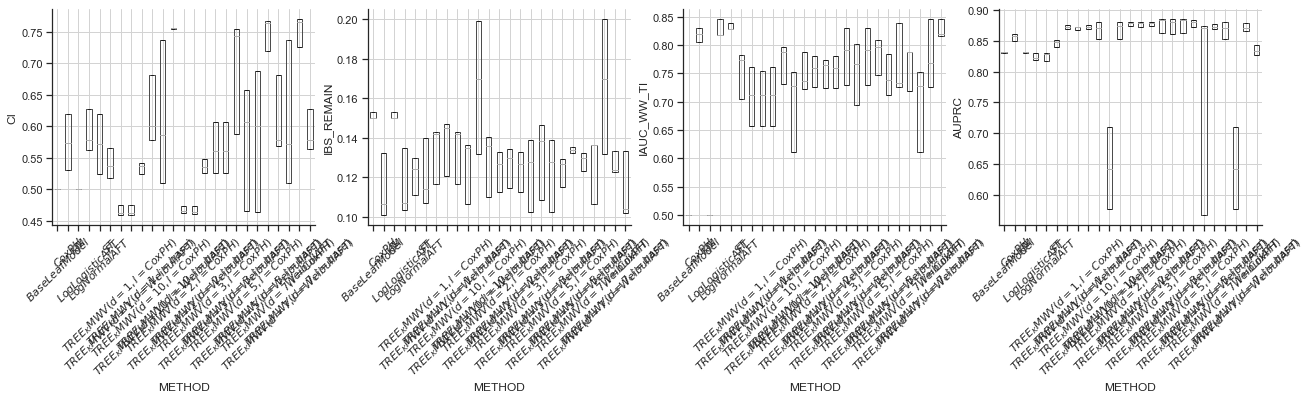

In [22]:
METHOD_MAP = {
    "CRAID": "TREE",
    "BootstrapCRAID": "BSTR", 
    "ParallelBootstrapCRAID": "PBSTR",
    "BoostingCRAID": "BOOST", 
    "IBSCleverBoostingCRAID": "BSTR",
    "CoxPHSurvivalAnalysis": "CoxPH",
    "SurvivalTree": "ST",
    "RandomSurvivalForest": "RSF",
    "ComponentwiseGradientBoostingSurvivalAnalysis": "CWGBSA",
    "GradientBoostingSurvivalAnalysis": "GBSA",
    "LeafSurviveAndHazard": "KM",
    "BaseLeafModeLL": "KM",
    "deepsurvCRAID": "DeepSurv",
    "coxtimeCRAID": "CoxTime"}

STAT_m = ['BaseLeafModeLL']
ML_m = ["CoxPH", 'ST']
SELF_m = ['TREE', 'TREE_KMWV']

def define_name(x):
    m = x["METHOD"]
    s = m.split("_")
    m = METHOD_MAP.get(s[0], s[0])
    if len(s) > 1:
#         m = s[1]
        m += "_" + s[1]
        # m += "_{" + s[1] + "}"
    s = str(x["ens_metric_name"])
    l_m = str(x["l_m"])
    cr = str(x["CRIT"])
    d = str(x["depth"])
    if len(d) > 0:
        return fr"${m}(d={d}, l={l_m})$"
#         return fr"${m}({cr})$"
    return fr"${m}$"

def find_best_index(df):
    ens_name = "IBS_REMAIN"
    
    if ens_name in metr.DESCEND_METRICS:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=True).index[:5].tolist()
    else:
        best_index = df[ens_name + "_CV_mean"].sort_values(ascending=False).index[:5].tolist()
    return best_index

def add_star_top3(column, filter_self=False):
    if filter_self:
        top_index = column[column.index != column.name.replace('_', '-')].argsort()
    else:
        top_index = column.argsort()
        
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        top3_index = top_index[:3]
    else:
        top3_index = top_index[-3:]
    column.iloc[top3_index] = "\\textbf{" + column.iloc[top3_index].astype(str) + "}"
    return column

def rank_values(column, filter_self=False):
    top_index = column.argsort().argsort()
    if column.name.split("_")[0] in metr.DESCEND_METRICS:
        return top_index + 1
    return top_index.shape[0] - top_index

def pair_compare_load(dataset, group, ch_met):
    dfs = []
    for c_m in ch_met:   
        datasets_sc = f"{c_m}_STRATTIME+_tree_{dataset}_CV_full.xlsx"
        df_sc = pd.read_excel(os.path.join(glob_dir, datasets_sc))
        df_sc["METHOD"] = df_sc["METHOD"]  + "_KMWV"
        dfs.append(df_sc)
    
        datasets_sc = f"{c_m}_STRATTIME+_scsurv_{dataset}_CV_full.xlsx"
        dfs.append(pd.read_excel(os.path.join(glob_dir, datasets_sc)))

    tg_metrs_1 = ["CI", "IBS_REMAIN", "IAUC_WW_TI", "AUPRC"]  # , "LOGLIKELIHOOD"]  # BAL_AUPRC
    tg_metrs = ["CI_mean", "IBS_REMAIN_mean", "IAUC_WW_TI_mean", "AUPRC_mean"]  #, "LOGLIKELIHOOD_mean"]
    new_metrs = tg_metrs_1
    
    df = pd.concat(dfs, ignore_index=True)
    
    df["ens_metric_name"] = df["PARAMS"].apply(lambda x: eval(x).get("ens_metric_name", ""))
    
    df["l_m"] = df["PARAMS"].apply(lambda x: eval(x).get("leaf_model", ""))
    df["depth"] = df["PARAMS"].apply(lambda x: eval(x).get("depth", ""))
    df["METHOD"] = df.apply(define_name, axis=1)
    df = df[~df["METHOD"].isin(["$RSF$", "$GBSA$", "$CWGBSA$"])]
    df = df.loc[df.groupby('METHOD')["IBS_REMAIN_mean"].idxmin()]
    df["METHOD"] = df["METHOD"].astype("category")
    
    f, axes = plt.subplots(1, 4, figsize=(21, 4))
    l_df = []
    for i, v in enumerate(tg_metrs_1):
        df[new_metrs[i]] = df[tg_metrs_1[i]]
        v = new_metrs[i]
        df[v] = df[v].apply(lambda x: np.array(list(map(float, x[1:-1].split()))))
        explode_res = df[[v, "METHOD"]].set_index(['METHOD']).apply(lambda x: x.explode()).reset_index()
        l_df.append(explode_res.groupby(by="METHOD").agg(lambda x: f"{x.mean():.4f}"))
        axes[i] = explode_res.boxplot(column=v, by="METHOD", figsize=(10, 10), rot=45, ax=axes[i], showfliers=False, whis=0)
        axes[i].set_ylabel(v)
        axes[i].set_title("")
    res_table = pd.concat(l_df, axis=1)#.astype(float).round(4)
    res_table.index = list(map(lambda x: x.replace("\lambda",'l'), res_table.index))
    res_table.columns = list(map(lambda x: x.replace("$",''), res_table.columns))
#     res_table.index = "$" + res_table.index + "$"
    
    print(res_table)
    res_table_star = res_table.copy()
#     res_table_star = res_table_star.apply(add_star_top3)
    res_table_star.to_csv(os.path.join(glob_dir, f"{dataset}_agg.csv"), sep="&")
    plt.suptitle("")
    plt.show()
    return res_table.apply(rank_values) # df

ch_metrs = ["IBS_REMAIN"]
df_l = []
for ds in ["backblaze16_18", "backblaze18_21", "backblaze21_23"]:
    print("="*10, ds, "="*10)
    df = pair_compare_load(ds, "", ch_metrs)
    df_l.append(df)